In [1]:
# Google Colab users need to execute the following to get the neural_network module

# ! rm -fr CS-539-project
# ! git clone https://github.com/mkpro118/CS-539-project.git

# import sys
# sys.path.insert(0, 'CS-539-project')

In [2]:
# This was the very first experiment, and it wasn't good at all
# See Custom Model Experiment.ipynb for better stuff

# Love this library, huge thanks to the ppl who made it
import numpy as np

# load the data
# See more about this in data/__init__.py
from data import load_data

data = load_data()

X, y = data.data.astype('float32'), data.labels
labels, names =  data.unique_labels, data.unique_label_names
input_shape = data.shape

# Sanity Check
print(f'X.shape      = {X.shape}')
print(f'y.shape      = {y.shape}')
print(f'labels.shape = {labels.shape}')
print(f'Label names  = {", ".join(names)}')

X.shape      = (651, 3, 224, 224)
y.shape      = (651,)
labels.shape = (5,)
Label names  = bishop, knight, pawn, queen, rook


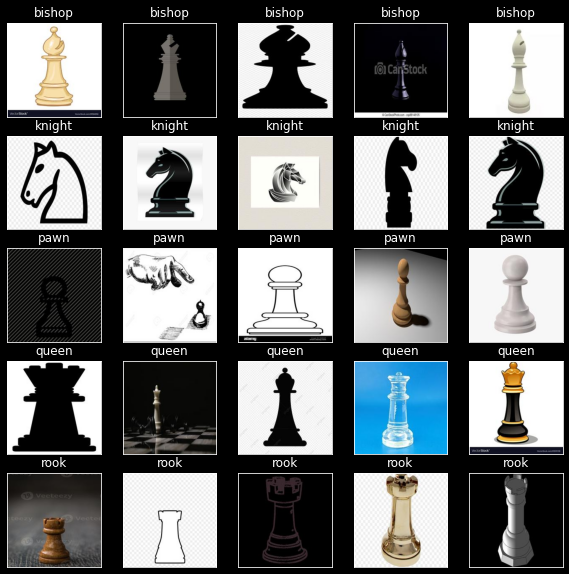

In [5]:
# Visualize the data

# Following function returns a random sample of n 
# data points across all labels
def sample(X, y, samples):
    unique_ys = np.unique(y, axis=0)
    result = []
    for unique_y in unique_ys:
        val_indices = np.argwhere(y==unique_y).flatten()
        random_samples = np.random.choice(val_indices, samples, replace=False)
        result.extend(map(lambda x:(x, unique_y), X[random_samples]))
    return result
    

_X = sample(X, y, 5) # get 5 samples per label

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('dark_background')

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axs = axs.flatten()
for i, (ax, (a, b)) in enumerate(zip(axs, _X)):
    ax.imshow(a.astype(int).transpose(1, 2, 0)) # transpose since data has channels first
    ax.set_title(f'{names[i // 5]}')
    ax.tick_params(
        left=False,
        labelleft=False,
        labelbottom=False,
        bottom=False
    )

plt.show()

In [6]:
# Partition the data, stratified by default

from neural_network.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (453, 3, 224, 224)
y_train.shape = (453,)
X_test.shape  = (198, 3, 224, 224)
y_test.shape  = (198,)


In [7]:
# Further partition, stratified

from neural_network.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
cv_splitter = skf.split(X_train, y_train)

In [8]:
#  Categorize labels to one hot encoded

from neural_network.preprocess import OneHotEncoder

encoder = OneHotEncoder().fit(labels)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

print(f'y_train.shape = {y_train.shape}')
print(f'y_test.shape  = {y_test.shape}')

y_train.shape = (453, 5)
y_test.shape  = (198, 5)


In [9]:
# Define a model

from neural_network.model import Sequential

net = Sequential()

In [10]:
# Add layers

from neural_network.layers import Convolutional, Dense, Flatten, BatchNormalization

net.add(
    Convolutional(filters=4, kernel_size=7, input_shape=input_shape),
    Convolutional(filters=2, kernel_size=5),
    BatchNormalization(),
    Convolutional(filters=1, kernel_size=3, activation='tanh'),
    Flatten(),
    Dense(128, activation='tanh'),
    Dense(64, activation='sigmoid'),
    BatchNormalization(),
    Dense(16, activation='tanh'),
    Dense(5, activation='softmax')
)

In [11]:
# Build the model
net.compile(cost='crossentropy', metrics=['accuracy_score'])

net.summary()

Sequential Model: 'Sequential Model' with 10 layers
Input Shape: (3, 224, 224)
----------------------------------------------------------------------------------------
|  # |       Layer        |                            Info                            |
----------------------------------------------------------------------------------------
|  1 |   Convolutional    | Convolutional Layer with 4 filters, 3 channels, 7x7 kernel |
|  2 |   Convolutional    | Convolutional Layer with 2 filters, 4 channels, 5x5 kernel |
|  3 | BatchNormalization |                 Batch Normalization Layer                  |
|  4 |   Convolutional    | Convolutional Layer with 1 filter, 2 channels, 3x3 kernel  |
|  5 |      Flatten       |                       Flatten Layer                        |
|  6 |       Dense        |                 Dense Layer with 128 nodes                 |
|  7 |       Dense        |                 Dense Layer with 64 nodes                  |
|  8 | BatchNormalization |    

In [12]:
# Instead of training multiple models,
# to improve accuracy, we train the same model
# 5 times on the different folds

for train, validate in cv_splitter:
    net.fit(
        X_train[train],
        y_train[train],
        epochs=50,
        batch_size=64,
        validation_data=(X_train[validate], y_train[validate]),
        verbose=True
    )

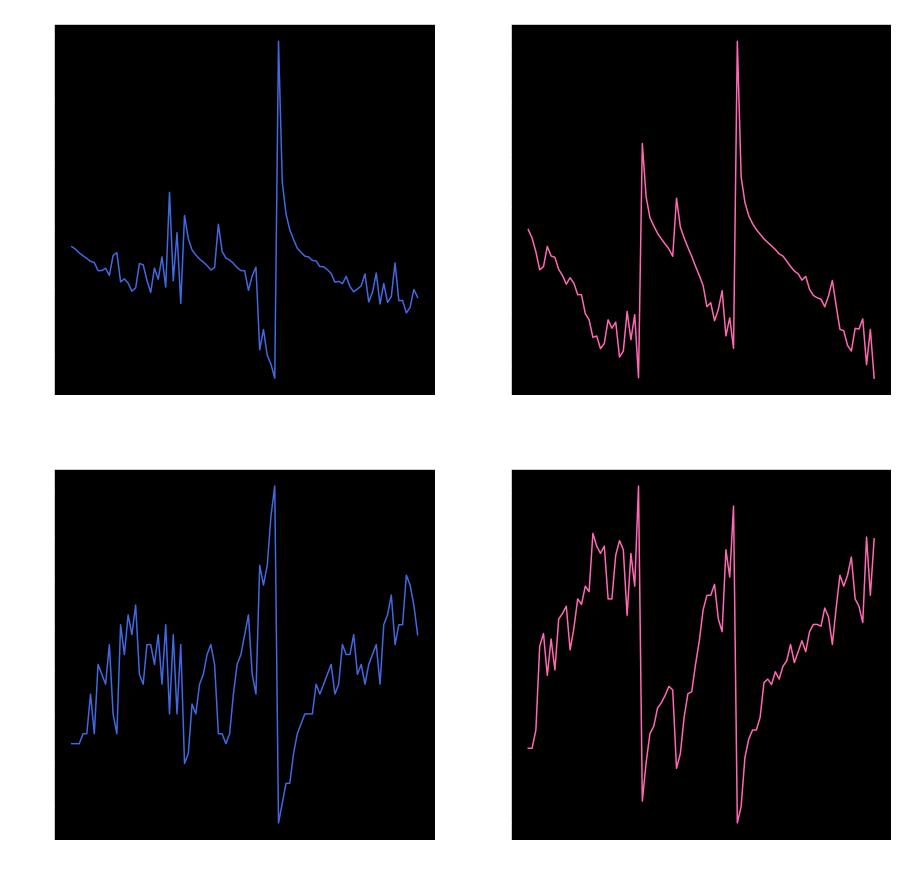

In [13]:
# Plot model's learning via accuracy and loss
# Warning, the rerults are not good

validation_history = net.history['validation']
model_history = net.history['overall']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

ax1.plot(
    np.arange(len(validation_history['loss'])),
    validation_history['loss'],
    color='royalblue'
)
ax2.plot(
    np.arange(len(model_history['loss'])),
    model_history['loss'],
    color='hotpink'
)
ax3.plot(
    np.arange(len(validation_history['accuracy_score'])),
    validation_history['accuracy_score'],
    color='royalblue'
)
ax4.plot(
    np.arange(len(model_history['accuracy_score'])),
    model_history['accuracy_score'],
    color='hotpink'
)

for ax in (ax1, ax2):
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

for ax in (ax3, ax4):
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)

    
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xticks(np.linspace(1, len(model_history['loss']), 10, dtype=int))
    ax.set_xticklabels(map(str, np.linspace(1, len(model_history['loss']), 10, dtype=int)))

ax1.set_title('Validation', fontsize=16)
ax2.set_title('Overall', fontsize=16)
ax3.set_title('Validation', fontsize=16)
ax4.set_title('Overall', fontsize=16)

plt.show()

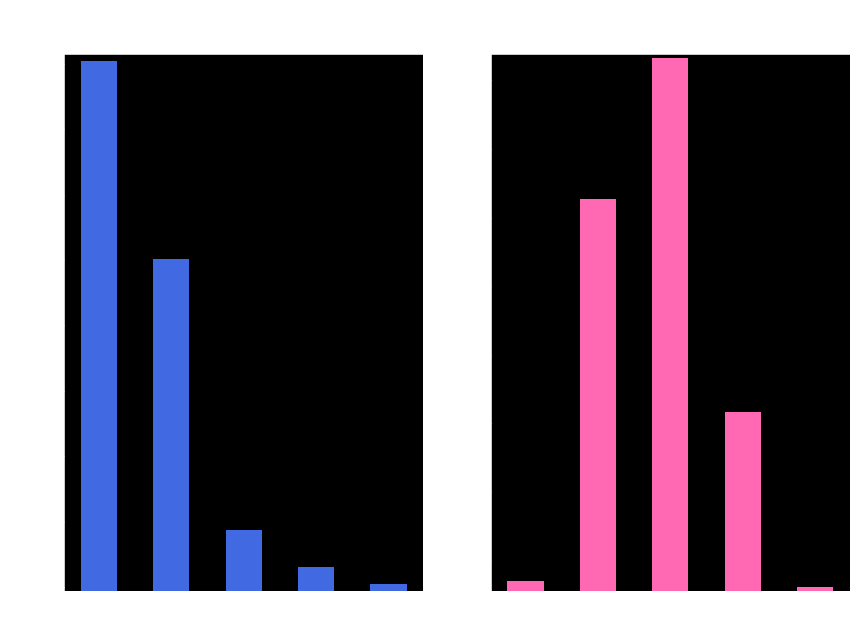

In [14]:
# We checkpoint the 5 best models by default
# Let's see how the best models perform
# By perform we mean accuracies and loss 
# on the entire training dataset
# The results were horrendous, so I haven't 
# bothered to predict the holdout data

best_models = net.checkpoints

best_accuracies = np.around([acc for _, acc, _ in best_models], 4)
best_losses = np.around([loss for _, _, loss in best_models], 4)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))

fig.suptitle('Best Models', fontsize=20)

ax1.bar(np.arange(len(best_accuracies), dtype=int) + 1, best_accuracies, color='royalblue', width=0.5)
ax1.set_title('Best Accuracies', fontsize=18)
ax1.set_xlabel('Models', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.set_xticks(np.arange(len(best_accuracies), dtype=int) + 1)
ax1.set_xticklabels(map(lambda x: f'#{x}', np.arange(len(best_accuracies), dtype=int) + 1))
ax1.set(ylim=[min(best_accuracies) - 0.001, max(best_accuracies) + 0.001])
ax1.tick_params(axis='both', labelsize=14)

ax2.bar(np.arange(len(best_losses), dtype=int) + 1, best_losses, color='hotpink', width=0.5)
ax2.set_title('Best Losses', fontsize=18)
ax2.set_xlabel('Models', fontsize=16)
ax2.set_ylabel('Loss', fontsize=16)
ax2.set_xticks(np.arange(len(best_losses), dtype=int) + 1)
ax2.set_xticklabels(map(lambda x: f'#{x}', np.arange(len(best_losses), dtype=int) + 1))
ax2.set(ylim=[min(best_losses) - 0.001, max(best_losses) + 0.001])
ax2.tick_params(axis='both', labelsize=14)

fig.tight_layout()
plt.show()